# Movie recommendation System

In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from sklearn import model_selection
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
#movies = pd.read_csv("/Users/sridhar/Desktop/Semester 2/Projects/Movie Recomendation System/Source code/ml-latest-small/movies.csv")
#ratings = pd.read_csv("/Users/sridhar/Desktop/Semester 2/Projects/Movie Recomendation System/Source code/ml-latest-small/ratings.csv")

# Database Used: MongoDB

In [2]:
import pymongo


client = pymongo.MongoClient("mongodb://127.0.0.1:27017/?directConnection=true&serverSelectionTimeoutMS=2000&appName=mongosh+1.1.9")

# Database Name
db = client["MovieRecommendation"]

# Collection Name
col1 = db["Movies"].find()
col2 = db["Ratings"].find()
movies =  pd.DataFrame(list(col1))
ratings = pd.DataFrame(list(col2))
movies = movies.drop(['_id'], axis = 1)
ratings = ratings.drop(['_id'], axis = 1)

In [3]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
movies.shape

(9742, 3)

In [5]:
movies.tail()

,movieId,title,genres
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation
9741,193609,Andrew Dice Clay: Dice Rules (1991),Comedy


In [6]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [7]:
ratings.shape

(100836, 4)

In [8]:
final_dataset = ratings.pivot(index='movieId',columns='userId',values='rating')
final_dataset.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,NaN,NaN,4.0,NaN,4.5,NaN,NaN,NaN,...,4.0,NaN,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,NaN,NaN,NaN,NaN,NaN,4.0,NaN,4.0,NaN,NaN,...,NaN,4.0,NaN,5.0,3.5,NaN,NaN,2.0,NaN,NaN
3,4.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN



# Data Cleaning

In [9]:
final_dataset.fillna(0,inplace=True)
final_dataset.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0



# Removing Noise from the data

Aggregating the number of users who voted and the number of movies that were voted.



In [10]:
no_user_voted = ratings.groupby('movieId')['rating'].agg('count')
no_movies_voted = ratings.groupby('userId')['rating'].agg('count')
print(no_user_voted)
print(no_movies_voted)

movieId
1         215
2         110
3          52
4           7
5          49
         ... 
193581      1
193583      1
193585      1
193587      1
193609      1
Name: rating, Length: 9724, dtype: int64
userId
1       232
2        29
3        39
4       216
5        44
       ... 
606    1115
607     187
608     831
609      37
610    1302
Name: rating, Length: 610, dtype: int64


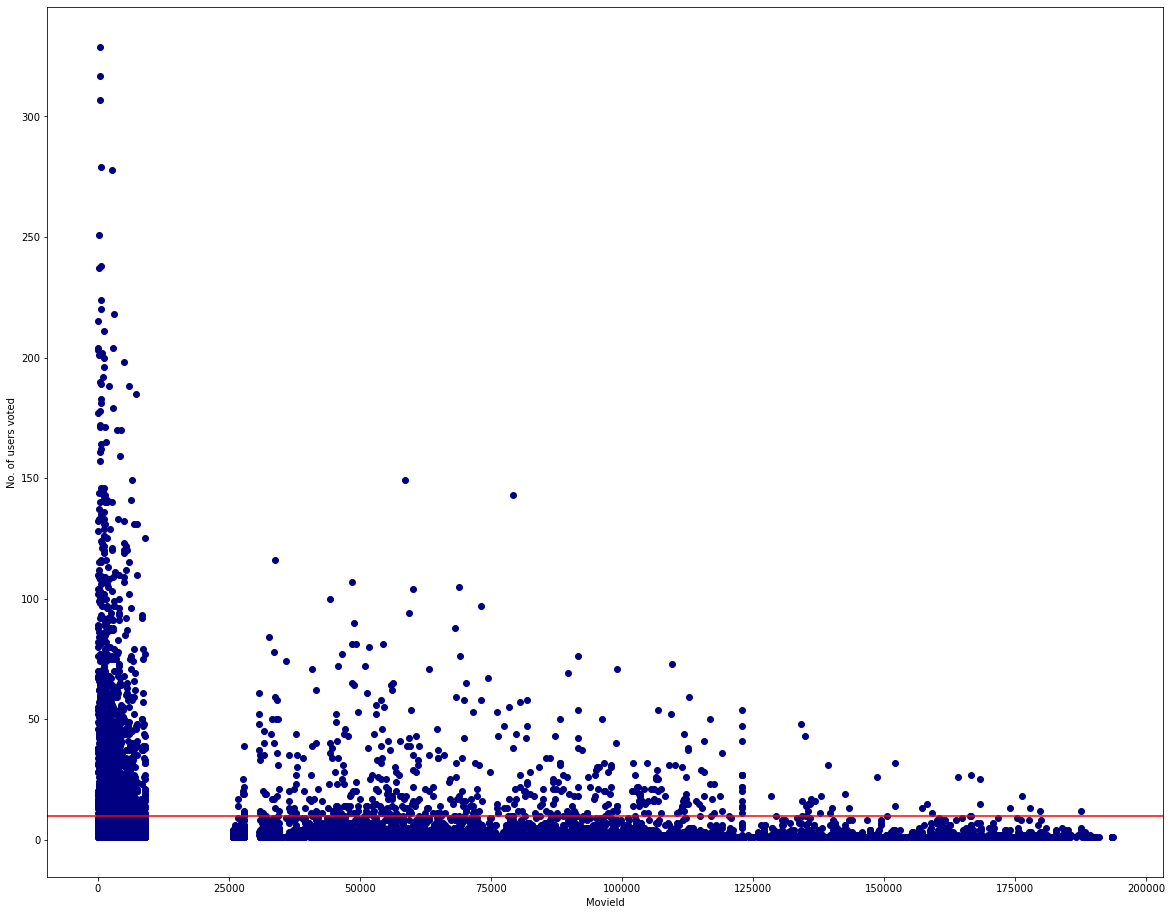

In [11]:
f,ax = plt.subplots(1,1,figsize=(20,16))
#ratings['rating'].plot(kind='hist')
plt.scatter(no_user_voted.index,no_user_voted,color='navy')
plt.axhline(y=10,color='r')
plt.xlabel('MovieId')
plt.ylabel('No. of users voted')
plt.show()

In [12]:
final_dataset = final_dataset.loc[no_user_voted[no_user_voted > 10].index,:]

In [13]:
final_dataset.shape

(2121, 610)

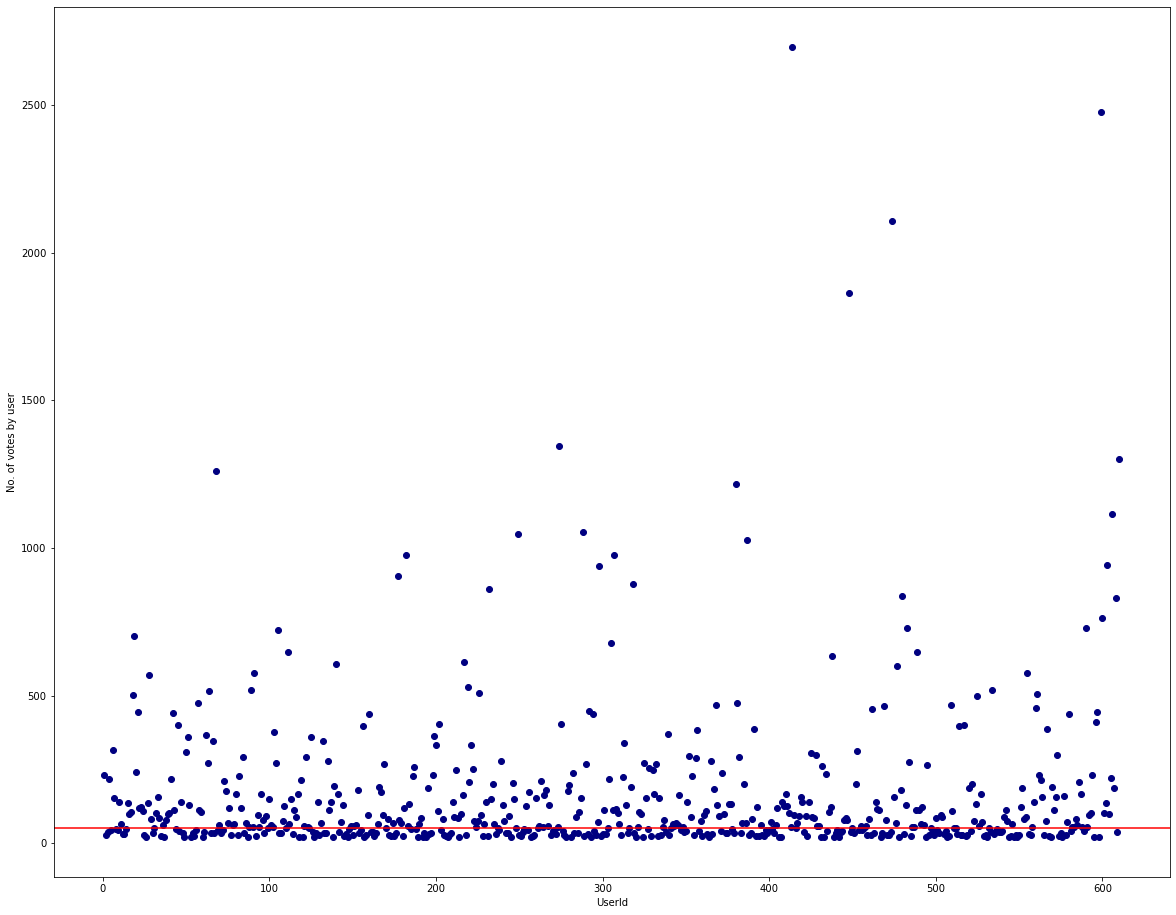

In [14]:
f,ax = plt.subplots(1,1,figsize=(20,16))
plt.scatter(no_movies_voted.index,no_movies_voted,color='navy')
plt.axhline(y=50,color='r')
plt.xlabel('UserId')
plt.ylabel('No. of votes by user')
plt.show()

In [15]:
final_dataset=final_dataset.loc[:,no_movies_voted[no_movies_voted > 50].index]
final_dataset

userId,1,4,6,7,10,11,15,16,17,18,...,600,601,602,603,604,605,606,607,608,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,4.5,0.0,0.0,2.5,0.0,4.5,3.5,...,2.5,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,5.0
2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,4.0,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0
3,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
5,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
6,4.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0,0.0,4.0,...,0.0,0.0,3.0,4.0,3.0,0.0,0.0,0.0,0.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
176371,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
177765,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



# Removing sparsity

In [16]:
sample = np.array([[0,0,3,0,0],[4,0,0,0,2],[0,0,0,0,1]])
sparsity = 1.0 - ( np.count_nonzero(sample) / float(sample.size) )
print(sparsity)

0.7333333333333334


In [17]:
csr_data = csr_matrix(final_dataset.values)
final_dataset.reset_index(inplace=True)
final_dataset.head()

userId,movieId,1,4,6,7,10,11,15,16,17,...,600,601,602,603,604,605,606,607,608,610
0,1,4.0,0.0,0.0,4.5,0.0,0.0,2.5,0.0,4.5,...,2.5,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,5.0
1,2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0
2,3,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
3,5,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
4,6,4.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0,0.0,...,0.0,0.0,3.0,4.0,3.0,0.0,0.0,0.0,0.0,5.0


In [18]:
csr_data

<2121x378 sparse matrix of type '<class 'numpy.float64'>'
	with 72893 stored elements in Compressed Sparse Row format>

In [39]:
arr = csr_matrix(csr_data, dtype=np.int8).toarray()
print(arr[1][2])

4


# Making the movie recommendation system model


In [20]:
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
model = knn.fit(csr_data)

# Making the recommendation function


The working principle is very simple. We first check if the movie name input is in the database and if it is we use our recommendation system to find similar movies and sort them based on their similarity distance and output only the top 10 movies with their distances from the input movie.

In [21]:
def get_movie_recommendation(movie_name):
    n_movies_to_reccomend = 10
    movie_list = movies[movies['title'].str.contains(movie_name)]  
    if len(movie_list):        
        movie_idx= movie_list.iloc[0]['movieId']
        movie_idx = final_dataset[final_dataset['movieId'] == movie_idx].index[0]
        distances , indices = knn.kneighbors(csr_data[movie_idx],n_neighbors=n_movies_to_reccomend+1)    
        rec_movie_indices = sorted(list(zip(indices.squeeze().tolist(),distances.squeeze().tolist())),key=lambda x: x[1])[:0:-1]
        recommend_frame = []
        for val in rec_movie_indices:
            movie_idx = final_dataset.iloc[val[0]]['movieId']
            idx = movies[movies['movieId'] == movie_idx].index
            recommend_frame.append({'Title':movies.iloc[idx]['title'].values[0],'Distance':val[1]})
        df = pd.DataFrame(recommend_frame,index=range(1,n_movies_to_reccomend+1))
        return df
    else:
        return "No movies found. Please check your input"

# Finally, Let’s Recommend some movies!

In [22]:
get_movie_recommendation('Iron Man')


,Title,Distance
1,Up (2009),0.368857
2,Guardians of the Galaxy (2014),0.368758
3,Watchmen (2009),0.368558
4,Star Trek (2009),0.366029
5,Batman Begins (2005),0.362759
6,Avatar (2009),0.310893
7,Iron Man 2 (2010),0.307492
8,WALL·E (2008),0.298138
9,"Dark Knight, The (2008)",0.285835
10,"Avengers, The (2012)",0.285319


In [25]:
get_movie_recommendation('Memento')


,Title,Distance
1,American Beauty (1999),0.389346
2,American History X (1998),0.388615
3,Pulp Fiction (1994),0.386235
4,"Lord of the Rings: The Return of the King, The...",0.371622
5,Kill Bill: Vol. 1 (2003),0.350167
6,"Lord of the Rings: The Two Towers, The (2002)",0.348358
7,Eternal Sunshine of the Spotless Mind (2004),0.346196
8,"Matrix, The (1999)",0.326215
9,"Lord of the Rings: The Fellowship of the Ring,...",0.316777
10,Fight Club (1999),0.272380


In [26]:
get_movie_recommendation('Fight Club')


,Title,Distance
1,Kill Bill: Vol. 2 (2004),0.336416
2,"Lord of the Rings: The Return of the King, The...",0.325792
3,Eternal Sunshine of the Spotless Mind (2004),0.324751
4,American Beauty (1999),0.311649
5,"Lord of the Rings: The Fellowship of the Ring,...",0.310610
6,Kill Bill: Vol. 1 (2003),0.302076
7,Pulp Fiction (1994),0.295286
8,American History X (1998),0.293905
9,Memento (2000),0.272380
10,"Matrix, The (1999)",0.229824


In [27]:
get_movie_recommendation('jsnckjsdcsc')

'No movies found. Please check your input'

In [28]:
get_movie_recommendation('Dark Knight')

,Title,Distance
1,Inglourious Basterds (2009),0.374613
2,Kill Bill: Vol. 1 (2003),0.364388
3,WALL·E (2008),0.364129
4,Avatar (2009),0.358937
5,"Hangover, The (2009)",0.348019
6,"Lord of the Rings: The Return of the King, The...",0.347528
7,"Dark Knight Rises, The (2012)",0.308688
8,Batman Begins (2005),0.306755
9,Iron Man (2008),0.285835
10,Inception (2010),0.213876


In [27]:
get_movie_recommendation('Dunkirk')


,Title,Distance
1,"Wolf of Wall Street, The (2013)",0.579830
2,The Hateful Eight (2015),0.563029
3,Paths of Glory (1957),0.556317
4,Guardians of the Galaxy 2 (2017),0.554890
5,Thor: Ragnarok (2017),0.554185
6,Sicario (2015),0.534809
7,The Artist (2011),0.519898
8,"Big Short, The (2015)",0.512684
9,Arrival (2016),0.509473
10,Blade Runner 2049 (2017),0.305579


In [28]:
get_movie_recommendation('Wolf of Wall Street')

,Title,Distance
1,Gone Girl (2014),0.460765
2,Whiplash (2014),0.454201
3,The Revenant (2015),0.447583
4,"Big Short, The (2015)",0.446903
5,Django Unchained (2012),0.430367
6,Shutter Island (2010),0.428555
7,The Martian (2015),0.425035
8,"Dark Knight Rises, The (2012)",0.412159
9,Her (2013),0.411062
10,Deadpool (2016),0.408168


In [29]:
get_movie_recommendation('Scarface')

,Title,Distance
1,American Psycho (2000),0.471233
2,Donnie Darko (2001),0.467661
3,"Godfather, The (1972)",0.466888
4,"Big Lebowski, The (1998)",0.466746
5,Fight Club (1999),0.464654
6,Kill Bill: Vol. 1 (2003),0.449598
7,"Departed, The (2006)",0.444265
8,Gangs of New York (2002),0.434544
9,Reservoir Dogs (1992),0.431892
10,Kill Bill: Vol. 2 (2004),0.416276


In [30]:
get_movie_recommendation('Godfather')

,Title,Distance
1,Fargo (1996),0.362356
2,"Silence of the Lambs, The (1991)",0.361809
3,American Beauty (1999),0.360804
4,Reservoir Dogs (1992),0.360162
5,Fight Club (1999),0.358305
6,One Flew Over the Cuckoo's Nest (1975),0.357212
7,Pulp Fiction (1994),0.352409
8,Star Wars: Episode IV - A New Hope (1977),0.349061
9,Goodfellas (1990),0.295961
10,"Godfather: Part II, The (1974)",0.154159


In [31]:
get_movie_recommendation('Pulp Fiction')

,Title,Distance
1,Goodfellas (1990),0.329255
2,American Beauty (1999),0.328066
3,"Matrix, The (1999)",0.319978
4,Fargo (1996),0.310647
5,Fight Club (1999),0.295286
6,"Usual Suspects, The (1995)",0.278261
7,Forrest Gump (1994),0.275716
8,Seven (a.k.a. Se7en) (1995),0.273683
9,"Shawshank Redemption, The (1994)",0.249804
10,"Silence of the Lambs, The (1991)",0.249232


In [32]:
get_movie_recommendation('Rosemary\'s Baby')

,Title,Distance
1,Chinatown (1974),0.575258
2,"Third Man, The (1949)",0.574224
3,Rebecca (1940),0.555199
4,Misery (1990),0.550489
5,"Shining, The (1980)",0.549078
6,Carrie (1976),0.549062
7,"Omen, The (1976)",0.520273
8,"Exorcist, The (1973)",0.499612
9,"Birds, The (1963)",0.482869
10,Psycho (1960),0.458052


In [33]:
get_movie_recommendation('Avengers: Infinity War')

,Title,Distance
1,Blade Runner 2049 (2017),0.467723
2,Black Panther (2017),0.420381
3,Arrival (2016),0.414004
4,Star Wars: The Last Jedi (2017),0.405511
5,Doctor Strange (2016),0.367247
6,Captain America: Civil War (2016),0.355038
7,Guardians of the Galaxy 2 (2017),0.318713
8,Untitled Spider-Man Reboot (2017),0.257129
9,Deadpool 2 (2018),0.225270
10,Thor: Ragnarok (2017),0.190964


In [23]:
print('Root Mean Squared Error: ')
RMSE = np.sqrt(np.mean(arr**2))
RMSE

Root Mean Squared Error: 


1.0774792624494953

In [24]:
 norm=np.amax(arr)-np.amin(arr)

In [25]:
Nomalized_RMSE = RMSE/norm
print('Normalised Root Mean Squared Error: ')
Nomalized_RMSE

Normalised Root Mean Squared Error: 


0.21549585248989905

In [26]:
knn = NearestNeighbors(metric='euclidean', algorithm='brute', n_neighbors=20, n_jobs=-1)
model = knn.fit(csr_data)

In [27]:
def get_movie_recommendation(movie_name):
    n_movies_to_reccomend = 10
    movie_list = movies[movies['title'].str.contains(movie_name)]  
    if len(movie_list):        
        movie_idx= movie_list.iloc[0]['movieId']
        movie_idx = final_dataset[final_dataset['movieId'] == movie_idx].index[0]
        distances , indices = knn.kneighbors(csr_data[movie_idx],n_neighbors=n_movies_to_reccomend+1)    
        rec_movie_indices = sorted(list(zip(indices.squeeze().tolist(),distances.squeeze().tolist())),key=lambda x: x[1])[:0:-1]
        recommend_frame = []
        for val in rec_movie_indices:
            movie_idx = final_dataset.iloc[val[0]]['movieId']
            idx = movies[movies['movieId'] == movie_idx].index
            recommend_frame.append({'Title':movies.iloc[idx]['title'].values[0],'Distance':val[1]})
        df = pd.DataFrame(recommend_frame,index=range(1,n_movies_to_reccomend+1))
        return df
    else:
        return "No movies found. Please check your input"

In [28]:
get_movie_recommendation('Avengers: Infinity War')

,Title,Distance
1,Scary Movie 4 (2006),13.313527
2,Captain America: Civil War (2016),13.086252
3,Wonder Woman (2017),12.932517
4,X-Men: Apocalypse (2016),12.519984
5,Batman v Superman: Dawn of Justice (2016),12.519984
6,Black Panther (2017),12.379418
7,Star Wars: The Last Jedi (2017),11.661904
8,Untitled Spider-Man Reboot (2017),11.335784
9,Thor: Ragnarok (2017),9.962429
10,Deadpool 2 (2018),9.137833


In [34]:
knn = NearestNeighbors(metric='manhattan', algorithm='brute', n_neighbors=20, n_jobs=-1)
model = knn.fit(csr_data)

In [35]:
def get_movie_recommendation(movie_name):
    n_movies_to_reccomend = 10
    movie_list = movies[movies['title'].str.contains(movie_name)]  
    if len(movie_list):        
        movie_idx= movie_list.iloc[0]['movieId']
        movie_idx = final_dataset[final_dataset['movieId'] == movie_idx].index[0]
        distances , indices = knn.kneighbors(csr_data[movie_idx],n_neighbors=n_movies_to_reccomend+1)    
        rec_movie_indices = sorted(list(zip(indices.squeeze().tolist(),distances.squeeze().tolist())),key=lambda x: x[1])[:0:-1]
        recommend_frame = []
        for val in rec_movie_indices:
            movie_idx = final_dataset.iloc[val[0]]['movieId']
            idx = movies[movies['movieId'] == movie_idx].index
            recommend_frame.append({'Title':movies.iloc[idx]['title'].values[0],'Distance':val[1]})
        df = pd.DataFrame(recommend_frame,index=range(1,n_movies_to_reccomend+1))
        return df
    else:
        return "No movies found. Please check your input"

In [36]:
get_movie_recommendation('Avengers: Infinity War')

,Title,Distance
1,Doctor Strange (2016),50.0
2,Batman v Superman: Dawn of Justice (2016),49.5
3,Captain America: Civil War (2016),48.5
4,Wonder Woman (2017),46.5
5,X-Men: Apocalypse (2016),44.5
6,Black Panther (2017),42.5
7,Star Wars: The Last Jedi (2017),36.0
8,Untitled Spider-Man Reboot (2017),36.0
9,Thor: Ragnarok (2017),27.5
10,Deadpool 2 (2018),24.0
